## Setup and Data Prep

In [2]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms
import torchvision
import cv2
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.utils import spectral_norm
import torch.nn.functional as F
import time as t
#plt.switch_backend('agg')
from torchvision import utils
import tensorflow as tf
from torch import autograd
from itertools import chain
import wandb

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [4]:
################  ONLY NECESSARY TO USE THE FIRST TIME WHEN THIS NOTEBOOK IS USED  #########################
# Dataset

trainval_folder = 'data\\PRPD_dataset\\TrainVal'
test_folder = 'data\\PRPD_dataset\\Test'

def get_dataset(path, split=''):
    images_path = []
    for dirpath, dirnames, files in os.walk(path):
        for file in files:
            path = os.path.join(dirpath, file)
            motor = os.path.basename(dirpath)
            defect = os.path.basename(os.path.dirname(dirpath))
            images_path.append((path, motor, defect, split))
    return images_path

trainval_path = os.path.join(os.path.dirname(os.getcwd()), trainval_folder)
test_path = os.path.join(os.path.dirname(os.getcwd()), test_folder)

classes = os.listdir(trainval_path)
print('Defects: {}'.format(classes))

trainval_ds = get_dataset(trainval_path, split='Train-val')
test_df = get_dataset(test_path, split='Test')

# Create pandas dataframe
df = pd.DataFrame(trainval_ds+test_df, columns=['Filename', 'Motor', 'Defect', 'Split'])
df['Class'], unique_labels = pd.factorize(df['Defect'])

Defects: ['corona', 'internal', 'surface']


In [5]:
class ImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df
        self.filenames = self.df['Filename'].values
        self.labels = self.df['Class'].values
        self.images = np.zeros((len(self.labels), 256, 256, 3), dtype= np.uint8)
        self.transform = transform
        self.getImages()

    def getImages(self):
        for idx, filename in enumerate(self.filenames):
            img = cv2.imread(filename)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_AREA)
            self.images[idx] = img

    def toTensor(self, data):
        image = data.transpose((2,0,1))
        return torch.from_numpy(image)

    def normalize(self, image_arr):
        return (image_arr - image_arr.min()) / (image_arr.max() - image_arr.min())
    
    def __getitem__(self, idx):
        x = self.images[idx]/255.0
        x = self.toTensor(x)
        y = self.labels[idx]
        if self.transform:
            x = self.transform(x)
        return x,y

    def __len__(self):
        return len(self.filenames)

In [18]:
train_transform = transforms.Compose([transforms.ToDtype(torch.float32, scale=True),
                                    #transforms.RandomRotation(degrees=(0,15)),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.RandomVerticalFlip(p=0.5),
                                    transforms.GaussianBlur(kernel_size=(5,5)),
                                    transforms.RandomAdjustSharpness(sharpness_factor=1.5),
                                    transforms.Resize((256,256))])
train_dataset = ImageDataset(df, transform=train_transform)
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

Input shape: torch.Size([32, 3, 256, 256])
Labels: tensor([1, 1, 2, 2, 1, 2, 0, 1, 0, 2, 0, 1, 2, 1, 0, 2, 1, 1, 2, 0, 0, 0, 0, 1,
        2, 2, 2, 2, 1, 0, 0, 1])


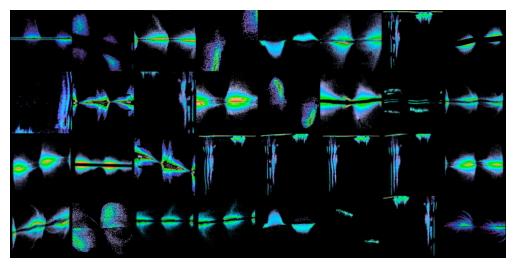

In [19]:
x, y = next(iter(train_loader))
print('Input shape:', x.shape)
print('Labels:', y)
# Create the grid from your batch tensor
grid = torchvision.utils.make_grid(x)
# Convert the tensor to numpy and transpose it for matplotlib (C, H, W) -> (H, W, C)
grid_np = grid.permute(1, 2, 0).numpy()
# Plot the combined channels
plt.imshow(grid_np)
plt.axis('off')
plt.show()

## Creating a Class-Conditioned UNet

The way we'll feed in the class conditioning is as follows:
- Create a standard `UNet2DModel` with some additional input channels  
- Map the class label to a learned vector of shape `(class_emb_size)`via an embedding layer
- Concatenate this information as extra channels for the internal UNet input with `net_input = torch.cat((x, class_cond), 1)`
- Feed this `net_input` (which has (`class_emb_size+1`) channels in total) into the UNet to get the final prediction

In this example I've set the class_emb_size to 4, but this is completely arbitrary and you could explore having it size 1 (to see if it still works), size 10 (to match the number of classes), or replacing the learned nn.Embedding with a simple one-hot encoding of the class label directly.

This is what the implementation looks like:

In [20]:
class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=10, class_emb_size=4):
    super().__init__()

    # The embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=256,           # the target image resolution
        in_channels=3 + class_emb_size, # Additional input channels for class cond.
        out_channels=3,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x, t, class_labels):
    # Shape of x:
    bs, ch, w, h = x.shape

    # class conditioning in right shape to add as additional input channels
    class_cond = self.class_emb(class_labels) # Map to embedding dimension
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

    # Feed this to the UNet alongside the timestep and return the prediction
    return self.model(net_input, t).sample # (bs, 1, 28, 28)

If any of the shapes or transforms are confusing, add in print statements to show the relevant shapes and check that they match your expectations. I've also annotated the shapes of some intermediate variables in the hopes of making things clearer.

## Training and Sampling

Where previously we'd do something like `prediction = unet(x, t)` we'll now add the correct labels as a third argument (`prediction = unet(x, t, y)`) during training, and at inference we can pass whatever labels we want and if all goes well the model should generate images that match. `y` in this case is the labels of the MNIST digits, with values from 0 to 9.

The training loop is very similar to the [example from Unit 1](https://github.com/huggingface/diffusion-models-class/blob/unit2/unit1/02_diffusion_models_from_scratch.ipynb). We're now predicting the noise (rather than the denoised image as in Unit 1) to match the objective expected by the default DDPMScheduler which we're using to add noise during training and to generate samples at inference time. Training takes a while - speeding this up could be a fun mini-project, but most of you can probably just skim the code (and indeed this whole notebook) without running it since we're just illustrating an idea.

In [21]:
# Create a scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

In [22]:
#@markdown Training loop (10 Epochs):

# Redefining the dataloader to set the batch size higher than the demo of 8
#train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# How many runs through the data should we do?
n_epochs = 50

# Our network
net = ClassConditionedUnet(3, 10).to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-5)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_loader):

        # Get some data and prepare the corrupted version
        x = x.to(device) * 2 - 1 # Data on the GPU (mapped to (-1, 1))
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        pred = net(noisy_x, timesteps, y) # Note that we pass in the labels y

        # Calculate the loss
        loss = loss_fn(pred, noise) # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)

  0%|          | 0/30 [00:00<?, ?it/s]

C:\Users\jazg2\miniconda3\envs\RL-env\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
C:\Users\jazg2\miniconda3\envs\RL-env\Lib\site-packages\diffusers\models\attention_processor.py:2383: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  hidden_states = F.scaled_dot_product_attention(
C:\Users\jazg2\miniconda3\envs\RL-env\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 866.00 MiB. GPU  (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\nativ

OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 

Once training finishes, we can sample some images feeding in different labels as our conditioning:

0it [00:00, ?it/s]

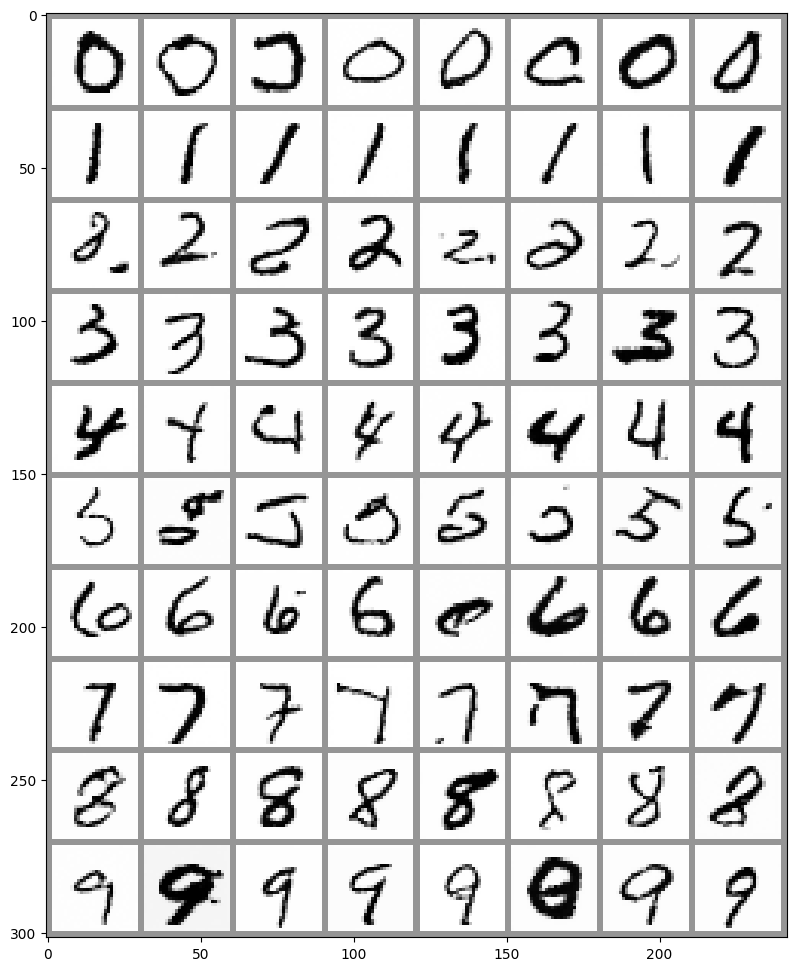

In [6]:
#@markdown Sampling some different digits:

# Prepare random x to start from, plus some desired labels y
x = torch.randn(30, 1, 256, 256).to(device)
y = torch.tensor([[i]*10 for i in range(3)]).flatten().to(device)

# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = net(x, t, y)  # Again, note that we pass in our labels y

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=3)[0], cmap='Greys')

There we go! We can now have some control over what images are produced.

I hope you've enjoyed this example. As always, feel free to ask questions in the Discord.

In [7]:
# Exercise (optional): Try this with FashionMNIST. Tweak the learning rate, batch size and number of epochs.
# Can you get some decent-looking fashion images with less training time than the example above?